# Forward modeling tutorial using mosaic images
## Fitting models

In [1]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from sim_tools import *
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



## Create spectra object

In [2]:
sp = Gen_spec('beams/o195.0_21156.g102.A.fits', 1.255, 'galaxy_spec_g102.npy')
spMB = Gen_MB_spec('beams/gnd_21156.beams.fits', 1.255, 'galaxy_spec_g102.npy','galaxy_spec_g141.npy')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3449: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3454: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3455: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 flt_files/ib3721xiq_flt.fits G141
2 flt_files/ib3721xmq_flt.fits G141
3 flt_files/ib3721xyq_flt.fits G141
4 flt_files/ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3420: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 flt_files/ib3725dyq_flt.fits G141
6 flt_files/ib3725e2q_flt.fits G141
7 flt_files/ib3725eeq_flt.fits G141
8 flt_files/ib3725eiq_flt.fits G141
9 flt_files/icat21cfq_flt.fits G102
10 flt_files/icat21coq_flt.fits G102
11 flt_files/icat21dgq_flt.fits G102
12 flt_files/icat21dlq_flt.fits G102
13 flt_files/icat25hcq_flt.fits G102
14 flt_files/icat25hiq_flt.fits G102
15 flt_files/icat25icq_flt.fits G102
16 flt_files/icat25iiq_flt.fits G102
17 flt_files/icxt51jvq_flt.fits G102
18 flt_files/icxt51jwq_flt.fits G102
19 flt_files/icxt51jzq_flt.fits G102
20 flt_files/icxt51k1q_flt.fits G102
21 flt_files/icxt52i0q_flt.fits G102
22 flt_files/icxt52i1q_flt.fits G102
23 flt_files/icxt52i4q_flt.fits G102
24 flt_files/icxt52i6q_flt.fits G102
25 flt_files/icxt53i9q_flt.fits G102
26 flt_files/icxt53iaq_flt.fits G102
27 flt_files/icxt53idq_flt.fits G102
28 flt_files/icxt53ifq_flt.fits G102
29 flt_files/icxt55krq_flt.fits G102
30 flt_files/icxt55ksq_flt.fits G102
31 flt_files/icxt55kvq_flt.fits G102
32 flt

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1354: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1359: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:545: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [5]:
age = np.arange(1.0,6.5,0.5)

In [6]:
def Chi_Squared(data, model, error):
    return np.sum(((data-model) / error)**2)

In [7]:
chisq = np.zeros(age.size)
chisqmb = np.zeros(age.size)

for i in range(age.size):
    sp.Sim_spec('model_spec/m0.019_a{0}_dt8.0_spec.npy'.format(age[i]))
    spMB.Sim_spec('model_spec/m0.019_a{0}_dt8.0_spec.npy'.format(age[i]))
    
    chisq[i] = Chi_Squared(sp.gal_fl, sp.fl, sp.gal_er)
    chisqmb[i] = Chi_Squared(spMB.gal_fl_102, spMB.fl_102, spMB.gal_er_102) + Chi_Squared(spMB.gal_fl_141, spMB.fl_141, spMB.gal_er_141)

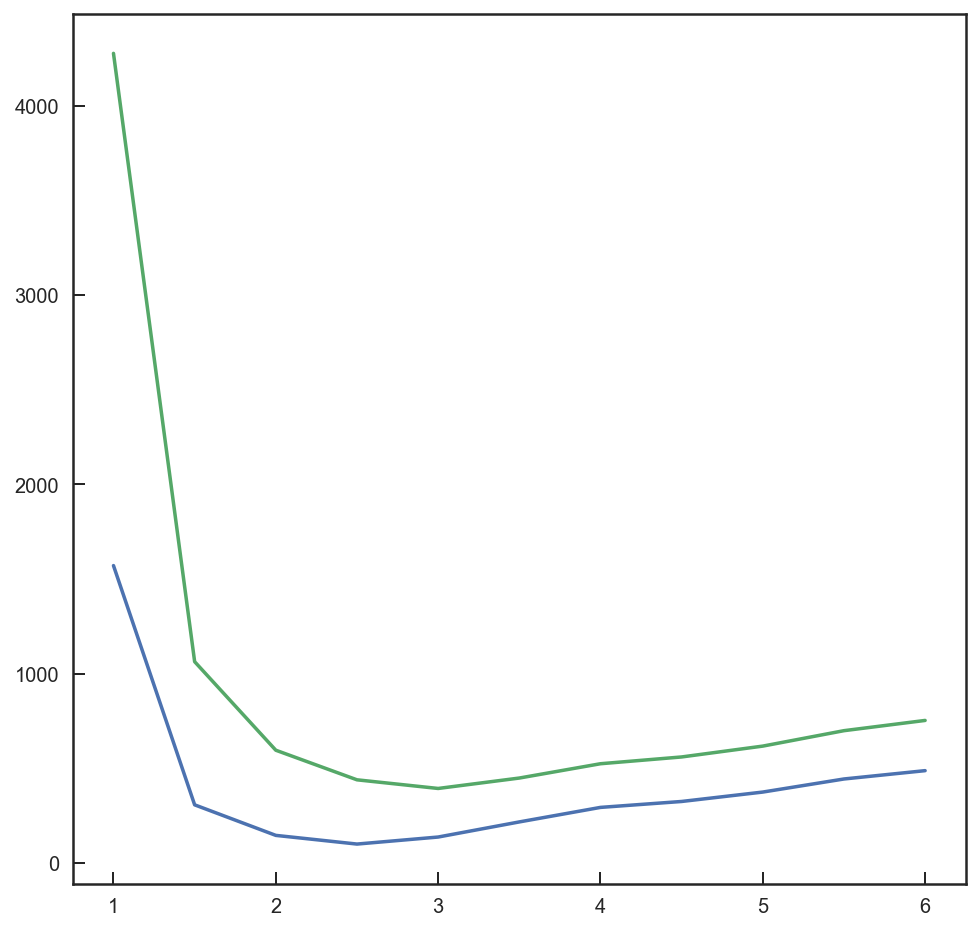

In [8]:
plt.figure(figsize=[8,8])
plt.plot(age,chisq)
plt.plot(age,chisqmb)

In [19]:
z = np.arange(1.2,1.3,0.001)

chisq = np.zeros(z.size)
chisqmb = np.zeros(z.size)

for i in range(z.size):
    sp.Sim_spec('model_spec/m0.019_a2.5_dt8.0_spec.npy',model_redshift=z[i])
    spMB.Sim_spec('model_spec/m0.019_a2.5_dt8.0_spec.npy',model_redshift=z[i])
    
    chisq[i] = Chi_Squared(sp.gal_fl, sp.fl, sp.gal_er)
    chisqmb[i] = Chi_Squared(spMB.gal_fl, spMB.fl, spMB.gal_er) 

Text(0.5,1,'min($\\chi^2$) = [1.255]')

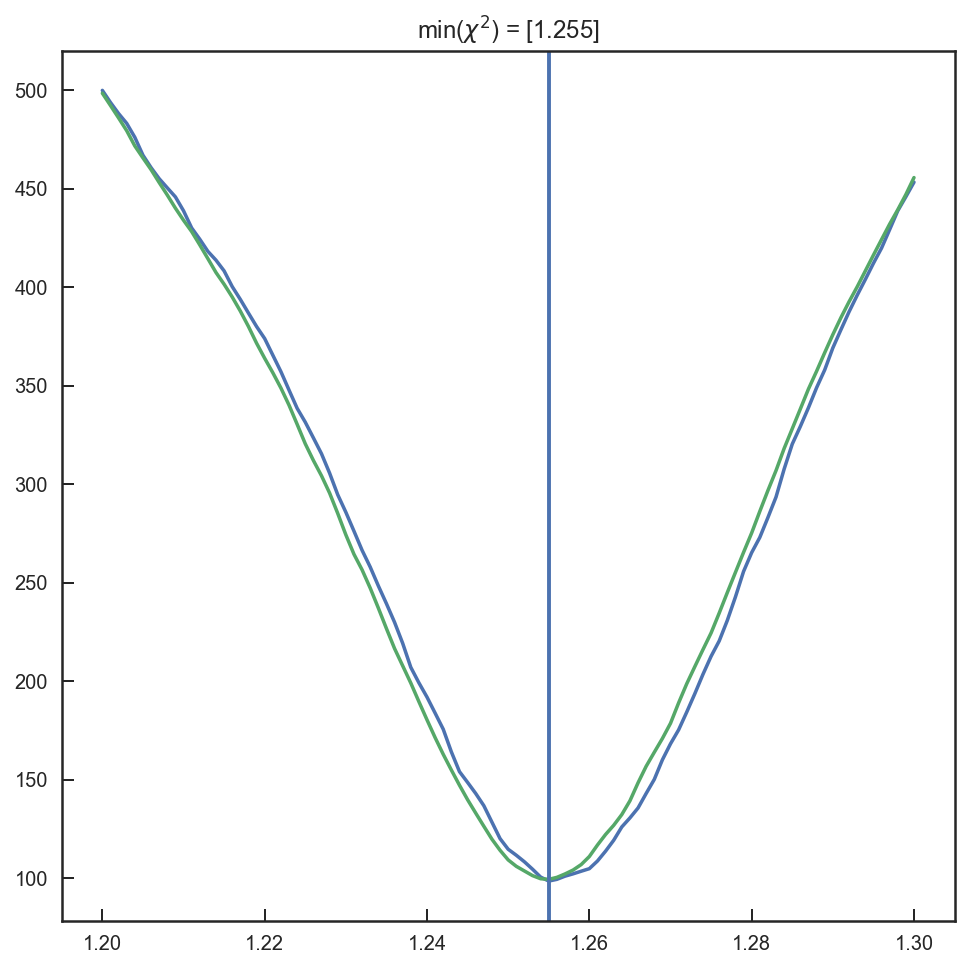

In [23]:
plt.figure(figsize=[8,8])
plt.plot(z,chisq)
plt.plot(z,chisqmb)
plt.axvline(z[chisq == min(chisq)])
plt.axvline(z[chisqmb == min(chisqmb)])
plt.title('min($\chi^2$) = {0}'.format(z[chisqmb == min(chisqmb)]))